# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import re

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [2]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
#print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
#print(html)
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
#print(rate_table)
# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 29.94, 即時現金賣出: 30.61


### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [3]:
'''

  Your code here
  
'''
res = requests.get(url)
res.encoding = 'utf-8'
soup = BeautifulSoup(res.text, "lxml")
ratetable = soup.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
for r in ratetable:
    currency=r.find('div', attrs={'class':'visible-phone print_hide'}).text.strip()
    buy=r.find(name='td',attrs={'data-table':'本行現金買入'}).text.strip()
    sell=r.find(name='td',attrs={'data-table':'本行現金賣出'}).text.strip()
    print("本行現金買入:{}, 本行現金賣出:{}".format(currency,buy,sell))

本行現金買入:美金 (USD), 本行現金賣出:29.94
本行現金買入:港幣 (HKD), 本行現金賣出:3.739
本行現金買入:英鎊 (GBP), 本行現金賣出:38.12
本行現金買入:澳幣 (AUD), 本行現金賣出:19.66
本行現金買入:加拿大幣 (CAD), 本行現金賣出:22.34
本行現金買入:新加坡幣 (SGD), 本行現金賣出:21.14
本行現金買入:瑞士法郎 (CHF), 本行現金賣出:30.18
本行現金買入:日圓 (JPY), 本行現金賣出:0.2648
本行現金買入:南非幣 (ZAR), 本行現金賣出:-
本行現金買入:瑞典幣 (SEK), 本行現金賣出:2.74
本行現金買入:紐元 (NZD), 本行現金賣出:18.75
本行現金買入:泰幣 (THB), 本行現金賣出:0.8296
本行現金買入:菲國比索 (PHP), 本行現金賣出:0.5219
本行現金買入:印尼幣 (IDR), 本行現金賣出:0.00188
本行現金買入:歐元 (EUR), 本行現金賣出:32.11
本行現金買入:韓元 (KRW), 本行現金賣出:0.02332
本行現金買入:越南盾 (VND), 本行現金賣出:0.00093
本行現金買入:馬來幣 (MYR), 本行現金賣出:6.062
本行現金買入:人民幣 (CNY), 本行現金賣出:4.223


## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

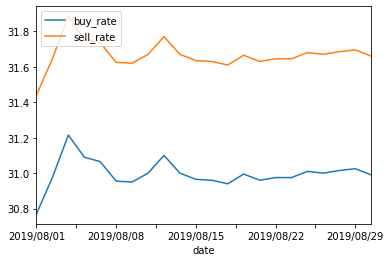

In [4]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')
#print(rate_table)
# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

In [5]:
'''

  Your code here

'''

'\n\n  Your code here\n\n'

美金 (USD)


<Figure size 720x576 with 0 Axes>

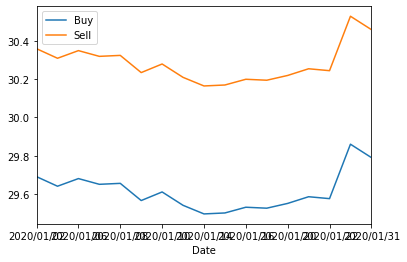

港幣 (HKD)


<Figure size 720x576 with 0 Axes>

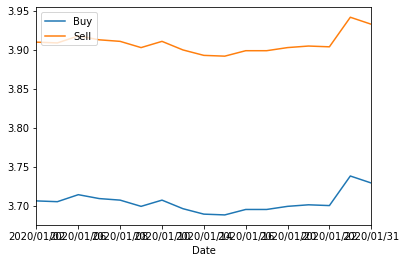

英鎊 (GBP)


<Figure size 720x576 with 0 Axes>

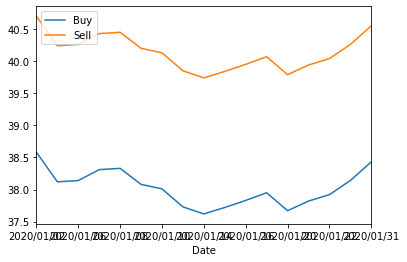

澳幣 (AUD)


<Figure size 720x576 with 0 Axes>

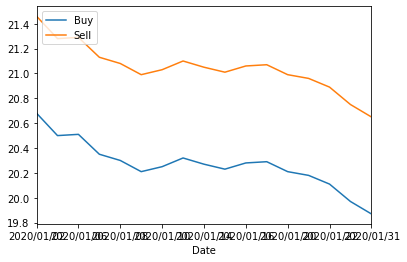

加拿大幣 (CAD)


<Figure size 720x576 with 0 Axes>

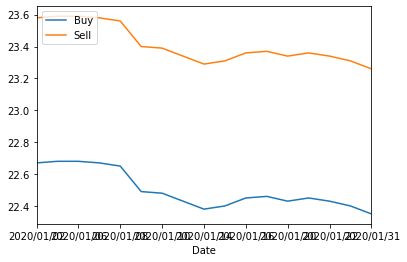

新加坡幣 (SGD)


<Figure size 720x576 with 0 Axes>

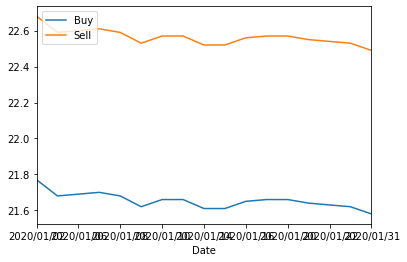

瑞士法郎 (CHF)


<Figure size 720x576 with 0 Axes>

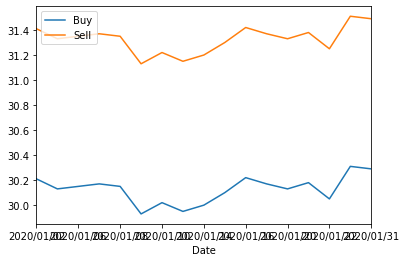

日圓 (JPY)


<Figure size 720x576 with 0 Axes>

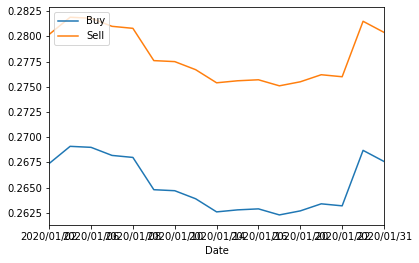

南非幣 (ZAR)


<Figure size 720x576 with 0 Axes>

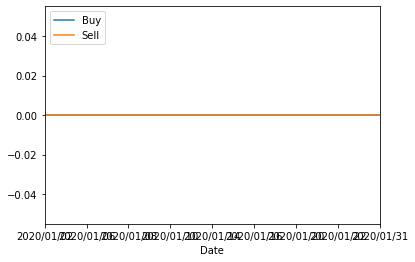

瑞典幣 (SEK)


<Figure size 720x576 with 0 Axes>

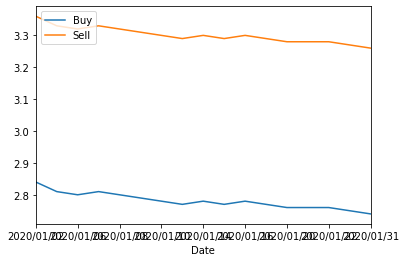

紐元 (NZD)


<Figure size 720x576 with 0 Axes>

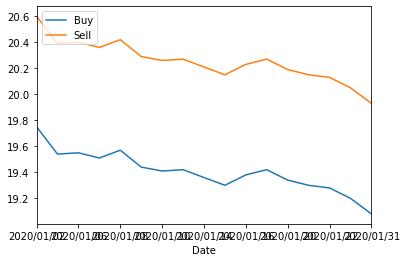

泰幣 (THB)


<Figure size 720x576 with 0 Axes>

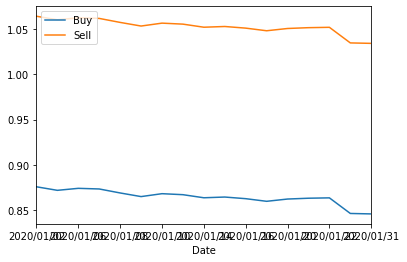

菲國比索 (PHP)


<Figure size 720x576 with 0 Axes>

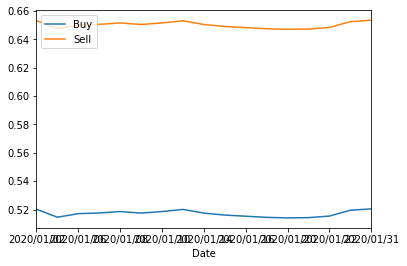

印尼幣 (IDR)


<Figure size 720x576 with 0 Axes>

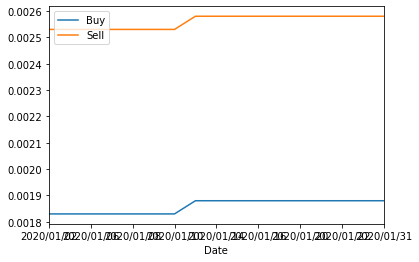

歐元 (EUR)


<Figure size 720x576 with 0 Axes>

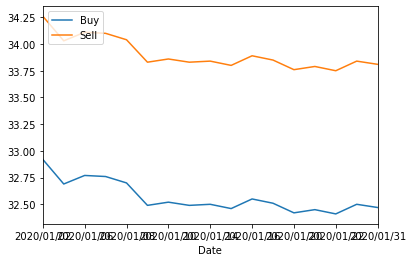

韓元 (KRW)


<Figure size 720x576 with 0 Axes>

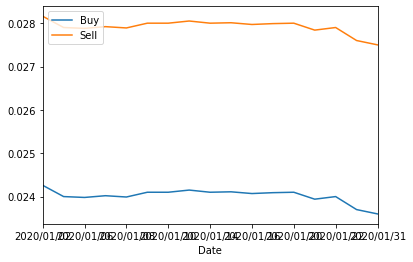

越南盾 (VND)


<Figure size 720x576 with 0 Axes>

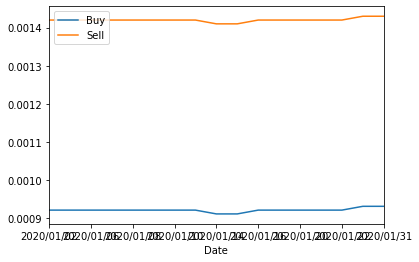

馬來幣 (MYR)


<Figure size 720x576 with 0 Axes>

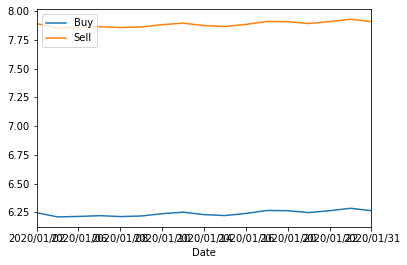

人民幣 (CNY)


<Figure size 720x576 with 0 Axes>

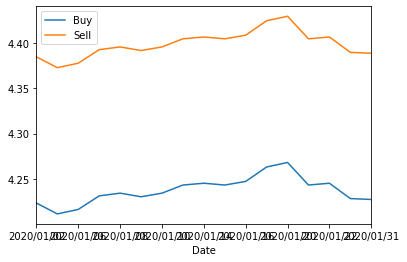

In [6]:
url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
res = requests.get(url)
soup = BeautifulSoup(res.text, 'lxml')
table_all = soup.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all('tr')

for tr in table_all:
    country = tr.find('div', attrs={'class':'visible-phone print_hide'}).text.strip()
    moneyname = re.search(r'[A-Z]+',country).group()
    url = 'https://rate.bot.com.tw/xrt/quote/2020-01/' + moneyname
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, 'lxml')
    
    date_list = list()
    buy_list = list()
    sell_list = list()
    
    table = soup.find(name='table', attrs={'class':'table table-striped table-bordered table-condensed table-hover'}).tbody.find_all('tr')
    for tr in table:
        date = tr.find('td',class_="text-center").a.text
        buy = tr.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})[0].text
        sell =  tr.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})[1].text
        date_list.append(datetime.strptime(date, '%Y/%M/%d').strftime('%Y/%M/%d'))
        buy_list.append(float(buy))
        sell_list.append(float(sell))
        
    # 把三個list作成DataFrame
    df = pd.DataFrame({'Date': date_list, 'Buy': buy_list, 'Sell': sell_list})
    
    df = df.set_index('Date')
    df = df.sort_index(ascending=True)
    print(country)
    
    #畫
    plt.figure(figsize=(10, 8))
    df[['Buy','Sell']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc="upper left")
    plt.show()